이 글은 [deeplearning.ai](https://learn.deeplearning.ai/courses/pretraining-llms)의 Pre-training LLM 강의를 듣고 나름대로 정리를 해본 글입니다. 자세한 내용은 강의를 참고해주세요. LLM 사전 학습은 컴퓨팅 파워가 많이 필요하기 때문에 사실상 개인이 수행하기에는 어려운 작업이지만, 이 글을 통해 LLM 사전 학습에 대한 전반적인 이해를 얻을 수 있을 것입니다.

# LLM 사전 학습이란?

대규모 언어 모델(LLM)을 처음부터 훈련하는 것은 막대한 계산 자원과 시간이 소요됩니다. 그래서 이미 방대한 텍스트 데이터를 활용해 사전 학습된 모델을 가져와 특정 작업에 맞게 소규모 데이터셋으로 미세 조정(Fine-tuning)하는 것이 일반적인 자연어 처리(NLP) 방법입니다. 그러나 이 글에서는 데이터를 수집하고 준비하는 첫번째 단계부터 LLM 모델을 사전 학습 시키는 아래와 같은 과정에 대해 배워보도록 하겠습니다.

```{mermaid}
graph LR;
    A[데이터 수집] --> B[데이터 패키징]
    B --> C[모델 학습]
    C --> D[모델 사용]
    D --> E[모델 평가]
```

In [ ]:
# | echo: false
import os
import warnings
from pathlib import Path
from typing import Any

import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")


def fix_torch_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


fix_torch_seed()

## 일반 사전학습 모델 불러오기

여기서 예시로 다루는 `TinySolar-248m-4k` 모델은 248M 매개변수(GPT2와 비슷한 규모)와 4096 토큰 컨텍스트 윈도우를 가진 작은 디코더 전용 소형 모델입니다. 이 모델은 Hugging Face 모델 라이브러리에서 [링크](https://huggingface.co/upstage/TinySolar-248m-4k) 확인 할 수 있습니다.

모델을 불러오는 과정은 다음 세 단계로 이루어집니다:
1. Hugging Face 모델 라이브러리에서 모델 경로 지정하기
2. `transformers` 라이브러리의 `AutoModelforCausalLM`을 사용하여 모델 불러오기
3. 같은 모델 경로에서 모델의 토크나이저 불러오기


# 데이터 준비

언어 모델을 학습할 때 사용하는 데이터의 품질은 매우 중요하며 사전 학습(Pre-training)에서 필요한 데이터와 미세 조정(Fine-tuning)에서의 데이터는 서로 다른 성질을 가지고 있습니다.

사전 학습에 사용되는 데이터는 일반적으로 더 대규모 데이터로 구조화가 덜 되어 있습니다. 반면에 미세 조정에서 사용되는 데이터는 특정 작업에 맞게 구조화된 데이터로 구성되어 있습니다. 비유하자면 사전 학습은 많은 책을 읽는 것과 같고, 미세 조정은 예비 고사를 치르는 것과 같습니다. 

여기에서는 학습 데이터를 확보하는 두 가지 방법을 살펴보겠습니다:

1. Hugging Face에서 기존 데이터셋 다운로드
2. 직접 수집한 텍스트 파일로 데이터셋 생성

두 경우 모두 결과는 `Datasets` 라이브러리의 일부인 Hugging Face `Dataset` 객체가 됩니다. Dataset의 속성과 사용 방법에 대한 자세한 내용은 [Hugging Face 웹사이트](https://huggingface.co/docs/datasets/en/index)에서 확인할 수 있습니다.

## Hugging Face에서 데이터 다운로드

여기서 다운로드하는 `upstage/Pretraining_Dataset` 데이터셋은 **Red Pajama**라는 훨씬 더 큰(1조 토큰 규모) 데이터셋의 서브셋입니다. 전체 데이터셋은 Hugging Face의 [이 링크](https://huggingface.co/datasets/togethercomputer/RedPajama-Data-1T)에서 확인할 수 있습니다.


In [ ]:
from datasets import load_dataset

pretraining_dataset = load_dataset("upstage/Pretraining_Dataset", split="train")
pretraining_dataset = pretraining_dataset.select_columns(["text"])
print(pretraining_dataset)

Dataset({
    features: ['text'],
    num_rows: 60000
})


In [ ]:
print(pretraining_dataset["text"][0])

In 1793 Zaman Shah, a grandson of Ahmad Shah Durrani, won a brief war of succession to become ruler of Afghanistan. The support of Painda Khan, chief of the Baraksai branch of the Durrani tribe, was decisive in his victory. In the next fifty year., the brothers of Zaman shah and the sons of Painda Khan were to dominate the affairs of Afghanistan. The Durrani tribe was very large with several branches and numerous clans. 1 Abmad Shah and his successors belonged to the Sadozai clan, but other clans, such as the Mohammedzai of Painda Khan, were larger and more powerful and this situation caused many problems.
Mahmud had revolted unsuccessfully several times with Persian backing, but now with Fateh Khan's help he was able to defeat Zaman who was captured and blinded. Mahmud's position was insecure however. Persian invasions threatened, the tribes were discontented, and another brother of Zaman, Shuja-ul-Mulk, was in arms against him. In 1803 Shuja succeeded in toppling Mahmud after three y

### 사전 학습 및 미세 조정 데이터 세트 비교  

다음 셀에서는 위에서 로드한 사전 학습 데이터 세트와 대조할 미세 조정 데이터 세트를 다운로드합니다. Alpaca 모델 및 명령어 튜닝 데이터 세트에 대한 자세한 내용은 [여기](https://crfm.stanford.edu/2023/03/13/alpaca.html)에서 확인할 수 있습니다.

In [ ]:
from datasets import load_dataset

instruction_dataset = load_dataset("c-s-ale/alpaca-gpt4-data", split="train")

i = 0

print(f"""Instruction: {instruction_dataset[i]["instruction"]}
Input: {instruction_dataset[i]["input"]}
Output: {instruction_dataset[i]["output"]}""")

Instruction: Give three tips for staying healthy.
Input: 
Output: 1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.

2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.

3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.


사전 학습 데이터가 단순한 원시 텍스트로 구성된 것과 달리 미세 조정용 데이터 세트는 질문-답변 쌍이나 명령어-응답 형태로 구조화되어 있다는 것을 알 수 있습니다. 또한 필요한 경우 추가 입력 컨텍스트를 포함할 수도 있습니다. 다만 여기에서는 앞으로는 비구조화된 사전 학습 데이터 세트만 사용할 것입니다.

## 직접 데이터 스크랩해오기


In [ ]:
from datasets import Dataset, concatenate_datasets

# 스크랩된 텍스트 데이터를 저장할 리스트 초기화
scrap_text = []
source_dir = Path("../data/input/scraped_text")

# 디렉토리 내 모든 파일 읽기
for file_path in source_dir.iterdir():
    if file_path.is_file():  # 파일인지 확인
        with file_path.open("r", encoding="utf-8") as file:
            scrap_text.append({"text": file.read()})

# 리스트를 Dataset 객체로 변환
scrap_text_dataset = Dataset.from_list(scrap_text)

# 기존 데이터셋과 새로 만든 데이터셋 결합
dataset = concatenate_datasets([pretraining_dataset, scrap_text_dataset])

# 결과 출력
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 60004
})


## 데이터 정리

이제 다음과 같은 데이터 정리 단계를 수행합니다:  

1. 너무 짧은 데이터 필터링  
2. 하나의 텍스트 내에서 반복된 부분 제거  
3. 중복된 문서 제거  
4. 비영어 텍스트를 제거하는 품질 필터 적용  

### 너무 짧은 데이터 제거

짧은 데이터는 모델이 학습하는 데 도움이 되지 않을 수 있습니다. 따라서 이번 단계에서는 너무 짧은 데이터를 제거합니다. 여기서는 3개 이하의 토큰을 가진 데이터를 제거합니다.

In [ ]:
import heapq
import re


def paragraph_length_filter(example):
    """페이지의 줄 수가 너무 적거나 줄 길이가 너무 짧으면 False를 반환합니다."""
    lines = example["text"].split("\n")
    # 가장 긴 3개의 줄의 길이를 계산하고, 그 중 최소 길이가 3보다 작은 경우 False 반환
    if len(lines) < 3 or min(heapq.nlargest(3, [len(line) for line in lines])) < 3:
        return False
    return True


print(f"데이터 정리 전 데이터의 수: {dataset.num_rows}")

# 필터링 작업 수행
dataset = dataset.filter(paragraph_length_filter, load_from_cache_file=False)

print(f"데이터 정리 후 데이터의 수: {dataset.num_rows}")

데이터 정리 전 데이터의 수: 60004


Filter:   0%|          | 0/60004 [00:00<?, ? examples/s]

데이터 정리 후 데이터의 수: 52355


### 훈련 샘플 내 반복된 텍스트 제거  

여기서는 각 샘플 내에서 반복된 텍스트를 제거합니다. 이를 통해 모델이 반복된 텍스트를 학습하는 것을 방지할 수 있습니다.

In [ ]:
def find_duplicates(paragraphs: list[str]) -> tuple[int, int]:
    """중복된 단락의 수와 문자 수를 계산합니다."""
    unique_paragraphs = set()
    duplicate_chars = 0
    duplicate_count = 0

    for paragraph in paragraphs:
        if paragraph in unique_paragraphs:
            duplicate_chars += len(paragraph)
            duplicate_count += 1
        else:
            unique_paragraphs.add(paragraph)

    return duplicate_count, duplicate_chars


def paragraph_repetition_filter(example: dict[str, str]) -> bool:
    """페이지에 중복이 너무 많으면 False를 반환합니다."""
    text = example["text"]
    paragraphs = re.compile(r"\n{2,}").split(text.strip())

    duplicate_count, duplicate_chars = find_duplicates(paragraphs)

    if duplicate_count / len(paragraphs) > 0.3:
        return False
    if duplicate_chars / len(text) > 0.2:
        return False

    return True


# 데이터셋에 필터 적용
filtered_dataset = dataset.filter(paragraph_repetition_filter, load_from_cache_file=False)
print(f"필터링 후 데이터셋 크기: {filtered_dataset.num_rows}")

Filter:   0%|          | 0/52355 [00:00<?, ? examples/s]

필터링 후 데이터셋 크기: 52326


### 중복 제거  

이 섹션에서는 전체 데이터 세트에서 중복된 샘플을 제거합니다. (이전 단계에서는 각 샘플 내에서 반복된 텍스트만 제거했습니다.)

In [ ]:
def deduplication(dataset: Dataset) -> Dataset:
    unique_texts = set()

    def dedup_func(example: dict[str, Any]) -> bool:
        """중복된 텍스트 항목을 제거합니다."""
        if example["text"] in unique_texts:
            return False
        unique_texts.add(example["text"])
        return True

    deduplicated_dataset = dataset.filter(dedup_func, load_from_cache_file=False, num_proc=1)

    print(f"원래 데이터셋 크기: {dataset.num_rows}")
    print(f"중복 제거 후 데이터셋 크기: {deduplicated_dataset.num_rows}")

    return deduplicated_dataset


dataset = deduplication(dataset)

Filter:   0%|          | 0/52355 [00:00<?, ? examples/s]

원래 데이터셋 크기: 52355
중복 제거 후 데이터셋 크기: 43621


### 언어 필터링

여기서는 영어가 아닌 텍스트 샘플을 제거합니다. 이를 위해 `lingua-py`라는 언어 감지 라이브러리를 사용합니다. 자세한 내용은 [여기](https://github.com/pemistahl/lingua-py)에서 확인할 수 있습니다.

In [ ]:
from lingua import Language, LanguageDetectorBuilder

# 영어와 한국어 감지를 위한 언어 감지기 생성
detector = LanguageDetectorBuilder.from_languages(Language.ENGLISH, Language.KOREAN).build()

# 데이터셋에서 영어 텍스트만 필터링
dataset = dataset.filter(
    lambda x: detector.detect_language_of(x["text"].replace("\n", "")) == Language.ENGLISH,
    load_from_cache_file=False,
    num_proc=1,
)

# 필터링 후 데이터셋 크기 출력
print(f"제거 후 데이터셋 크기: {dataset.num_rows}")

Parameter 'function'=<function <lambda> at 0x7388a02aa7a0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Filter:   0%|          | 0/43621 [00:00<?, ? examples/s]

제거 후 데이터셋 크기: 43322


## 데이터 세트를 디스크에 저장  

Parquet 데이터 형식에 대한 자세한 내용은 [여기](https://parquet.apache.org/)에서 확인할 수 있습니다.

In [ ]:
output_dir = Path("../data/output")
file_name = "preprocessed_dataset.parquet"
file_path = output_dir / file_name

# 디렉토리가 존재하지 않으면 생성
output_dir.mkdir(parents=True, exist_ok=True)

# 파케이 파일로 저장
dataset.to_parquet(file_path)

print(f"데이터셋이 성공적으로 저장되었습니다: {file_path}")

Creating parquet from Arrow format:   0%|          | 0/44 [00:00<?, ?ba/s]

데이터셋이 성공적으로 저장되었습니다: ../data/output/preprocessed_dataset.parquet


이제 데이터 세트를 모델 학습에 사용할 수 있도록 패키징하는 방법을 배웁니다.  

# 데이터 패키징  

데이터 패키징은 토큰화(Tokenizing)와 패킹(Packing) 과정을 포함하며 각각의 역할은 아래와 같습니다.

- **토큰화(Tokenizing)**: 각 텍스트를 의미 있는 작은 단위(토큰)로 분할하는 과정  
- **패킹(Packing)**: 훈련 효율성을 높이기 위해 토큰을 최대 시퀀스 길이에 맞게 정리하는 과정  

## 토큰화 및 input_ids 만들기  

이전 단계에서 저장한 데이터 세트를 불러오는 것부터 시작합니다.

In [ ]:
import datasets

dataset = datasets.load_dataset("parquet", data_files=file_path.as_posix(), split="train")
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 43322
})


Hugging Face `Dataset` 객체의 `shard` 메서드를 사용하여 데이터 세트를 10개의 더 작은 조각(*shards*)으로 분할합니다. (*shard*는 깨진 유리 조각처럼 데이터를 나누는 개념입니다.) Sharding에 대한 자세한 내용은 [여기](https://huggingface.co/docs/datasets/en/process#shard)에서 확인할 수 있습니다.

In [ ]:
dataset = dataset.shard(num_shards=10, index=0)
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 4333
})


토크나이저를 불러오고, `input_ids`를 생성하는 데 사용할 수 있습니다. 이 과정은 데이터를 토큰화하고 토큰을 `input_ids`로 변환하는 과정입니다.


In [ ]:
from transformers import AutoTokenizer

model_path_or_name = "upstage/SOLAR-10.7B-v1.0"
tokenizer = AutoTokenizer.from_pretrained(
    model_path_or_name,
    use_fast=False,  # 참고: 긴 텍스트 샘플이 때때로 멈추는 경향이 있어 빠른 토큰화를 비활성화합니다. 대신 병렬 처리를 위해 map 함수와 datasets 라이브러리를 사용하겠습니다.
)
tokenizer.tokenize("I'm a short sentence")


# 헬퍼 함수 생성:
def tokenization(example):
    # 토큰화
    tokens = tokenizer.tokenize(example["text"])
    # 토큰을 ID로 변환
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    # <bos>, <eos> 토큰을 token_ids의 앞과 뒤에 추가
    # bos: 시퀀스 시작, eos: 시퀀스 끝
    token_ids = [tokenizer.bos_token_id] + token_ids + [tokenizer.eos_token_id]
    example["input_ids"] = token_ids

    # 최종 데이터셋의 총 토큰 수를 계산하는 데 이 열을 사용할 것입니다.
    example["num_tokens"] = len(token_ids)
    return example

사전 학습 데이터 세트의 모든 예제를 토큰화 합니다. 

> 이 과정은 시간이 오래 걸릴 수 있습니다.

In [ ]:
# 데이터셋의 각 예제에 tokenization 함수를 적용합니다.
# load_from_cache_file=False 옵션은 캐시된 결과를 사용하지 않고 항상 새로 계산하도록 합니다.
dataset = dataset.map(tokenization, load_from_cache_file=False)

# 변환된 데이터셋의 정보를 출력합니다.
print(dataset)

Map:   0%|          | 0/4333 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'num_tokens'],
    num_rows: 4333
})


In [ ]:
sample = dataset[3]  # 데이터셋에서 네 번째 샘플을 선택합니다.

print("text", sample["text"][:30])  # 샘플 텍스트의 처음 30자를 출력합니다.
print("\ninput_ids", sample["input_ids"][:30])  # 토큰화된 입력 ID의 처음 30개를 출력합니다.
print("\nnum_tokens", sample["num_tokens"])  # 샘플의 총 토큰 수를 출력합니다.

text A cool look at climate
Ian Sin

input_ids [1, 330, 5106, 913, 438, 11259, 13, 28737, 276, 318, 1505, 992, 2261, 2308, 302, 272, 1830, 11259, 2268, 11725, 297, 272, 6194, 684, 767, 6768, 905, 304, 5780, 1580]

num_tokens 3731


데이터셋의 총 토큰 수를 확인합니다.

In [ ]:
import numpy as np

total_tokens = np.sum(dataset["num_tokens"])
print(f"총 토큰 수: {total_tokens}")

총 토큰 수: 5689564


## 데이터 패킹

데이터 패킹은 여러 데이터를 효율적으로 하나의 데이터 블록으로 결합하는 과정입니다. 이 기술은 특히 자연어 처리(NLP) 작업에서 배치 처리 효율성을 높이는 데 중요합니다. 아래 다이어그램은 일반적인 워크플로우를 보여줍니다.

```{mermaid}
graph TD;
    B[Load Dataset];
    B --> C[Tokenize Each Example];
    C --> D[Create input_ids];
    D --> E[Pad Sequences to Max Length];
    E --> F[Pack Tokens into Batches];
```

1. 데이터셋 로드: 원시 텍스트 데이터를 메모리에 불러옵니다.
2. 토큰화: 각 예제 텍스트를 개별 토큰으로 분할합니다. 이는 단어, 하위 단어 또는 문자 수준에서 수행될 수 있습니다.
3. input_ids 생성: 토큰을 해당하는 정수 ID로 변환합니다. 이는 모델이 이해할 수 있는 형식입니다.
4. 시퀀스 패딩: 배치 내의 모든 시퀀스가 동일한 길이를 갖도록 짧은 시퀀스에 패딩을 추가합니다.
5. 배치로 토큰 패킹: 여러 예제의 토큰을 하나의 배치로 결합합니다.

마지막 단계에서 모든 예제의 input_ids를 하나의 리스트로 연결하는 것은 메모리 효율성과 처리 속도를 향상시키는 중요한 최적화 기법입니다. 이렇게 하면 모델이 한 번에 여러 예제를 처리할 수 있습니다. 이러한 패킹 기법은 GPU 메모리 사용을 최적화하고 병렬 처리 능력을 최대한 활용할 수 있어 전체적인 훈련 시간을 단축시킬 수 있습니다.

In [ ]:
# dataset의 "input_ids" 배열을 연결하여 하나의 배열로 만듭니다.
input_ids = np.concatenate(dataset["input_ids"])

# 연결된 배열의 길이를 출력합니다.
print(f"연결된 배열의 길이 {len(input_ids)}")

# 최대 시퀀스 길이를 설정합니다.
max_seq_length = 32

# 총 길이를 계산합니다. input_ids의 길이에서 max_seq_length로 나누어 나머지를 뺀 값입니다.
total_length = len(input_ids) - len(input_ids) % max_seq_length

# 계산된 총 길이를 출력합니다.
print(f"계산된 총 길이: {total_length}")

연결된 배열의 길이 5689564
계산된 총 길이: 5689536


리스트 끝에서 추가 토큰을 버려서 토큰의 수가 `max_seq_length`로 정확하게 나누어지도록 합니다.


In [ ]:
# input_ids 배열을 total_length 길이만큼 자릅니다.
input_ids = input_ids[:total_length]

# 잘린 배열의 shape(형상)을 출력합니다.
print(f"input_ids의 shape: {input_ids.shape}")

# input_ids 배열을 (행: -1, 열: max_seq_length) 형태로 재구조화하고, 데이터 타입을 int32로 변환합니다.
input_ids_reshaped = input_ids.reshape(-1, max_seq_length).astype(np.int32)

# 재구조화된 배열의 shape(형상)을 출력합니다.
print(f"input_ids_reshaped의 shape: {input_ids_reshaped.shape}")

# 재구조화된 배열의 데이터 타입을 출력합니다.
print(f"input_ids_reshaped의 데이터 타입: {type(input_ids_reshaped)}")

input_ids의 shape: (5689536,)
input_ids_reshaped의 shape: (177798, 32)
input_ids_reshaped의 데이터 타입: <class 'numpy.ndarray'>


Hugging Face 데이터 세트로 변환하려면 다음과 같이 합니다.

In [ ]:
# input_ids_reshaped를 리스트로 변환합니다.
input_ids_list = input_ids_reshaped.tolist()

# 변환된 리스트를 사용하여 새로운 Dataset 객체를 생성합니다.
packaged_pretrain_dataset = datasets.Dataset.from_dict({"input_ids": input_ids_list})

# 생성된 Dataset 객체의 정보를 출력합니다.
print(f"생성된 Dataset 객체: {packaged_pretrain_dataset}")

생성된 Dataset 객체: Dataset({
    features: ['input_ids'],
    num_rows: 177798
})


## 패킹된 데이터 세트 디스크에 저장

Hugging Face Dataset 객체를 디스크에 저장하는 방법은 다음과 같습니다. 

> `to_parquet()` 메서드는 데이터를 Parquet 파일 형식으로 저장합니다. Parquet는 효율적인 컬럼 기반 저장 형식으로, 대규모 데이터를 저장하고 처리하는 데 최적화되어 있습니다. Parquet 형식은 다른 데이터 분석 툴(예: pandas, Apache Spark 등)과 쉽게 호환됩니다. 데이터 세트를 다른 시스템 또는 다른 툴과 공유할 때 유용하며 압축과 성능 최적화 측면에서 효율적입니다.

In [ ]:
file_name = "packaged_pretrain_dataset.parquet"
file_path = output_dir / file_name

# 디렉토리가 존재하지 않으면 생성
output_dir.mkdir(parents=True, exist_ok=True)

# 파케이 파일로 저장
packaged_pretrain_dataset.to_parquet(file_path)

print(f"데이터셋이 성공적으로 저장되었습니다: {file_path}")

Creating parquet from Arrow format:   0%|          | 0/178 [00:00<?, ?ba/s]

데이터셋이 성공적으로 저장되었습니다: ../data/output/packaged_pretrain_dataset.parquet


In [ ]:
packaged_pretrain_dataset

Dataset({
    features: ['input_ids'],
    num_rows: 177798
})

In [ ]:
print(packaged_pretrain_dataset[0]["input_ids"][0:10])

[1, 560, 28705, 28740, 28787, 28774, 28770, 1054, 14886, 23452]


# 모델 훈련 준비하기

## 모델 구성

Meta의 Llama 모델 계열을 기반으로 모델을 구성할 것입니다. transformers 라이브러리에는 이 모델들과 함께 작업할 수 있는 여러 도구가 있으며, 이에 대해 [여기](https://huggingface.co/docs/transformers/main/en/model_doc/llama)에서 읽을 수 있습니다.

시작은 `LlamaConfig` 객체를 생성하여 모델의 아키텍처를 구성하는 것입니다.

In [ ]:
from transformers import LlamaConfig, LlamaForCausalLM


def print_nparams(model):
    """모델의 총 파라미터 개수를 계산하여 출력합니다."""
    nparams = sum(p.numel() for p in model.parameters())
    print(f"모델의 총 파라미터 개수: {nparams}")


# LlamaConfig 객체를 생성합니다.
config = LlamaConfig()
print(f"기본 설정: {config}")

기본 설정: LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "transformers_version": "4.37.2",
  "use_cache": true,
  "vocab_size": 32000
}



In [ ]:
# 모델 아키텍처를 변경하기 위해 설정 값을 업데이트합니다:
config.num_hidden_layers = 12  # 기본값 32에서 12로 감소
config.hidden_size = 1024  # 기본값 4096에서 1024로 감소 (1/4 축소)
config.intermediate_size = 4096  # 기본값 11008에서 4096으로 감소 (MLP 표현 차원, 약 1/3 축소)
config.num_key_value_heads = 8  # 기본값 num_attention_heads=32에서 8로 감소 (1/4 축소)
config.torch_dtype = "bfloat16"  # 정밀도를 감소
config.use_cache = False  # `True`는 gradient checkpointing과 호환되지 않음
print(f"업데이트된 설정: {config}")

업데이트된 설정: LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 12,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": false,
  "vocab_size": 32000
}



## 가중치 초기화

모델 훈련을 위한 가중치 초기화 방법에는 다음 4가지가 있습니다. 각각을 간략히 설명하고 4번째 방법인 depth upscaling 방법을 사용해 학습을 진행하겠습니다.
  
### 가중치 랜덤 초기화

모델의 가중치를 랜덤으로 초기화하는 방법입니다. 모든 가중치는 평균이 0이고 표준 편차가 0.02인 절단된 정규 분포(truncated normal distribution)에서 값을 설정합니다. 평균에서 2시그마(2σ)를 초과하는 값은 0으로 설정됩니다.

장점:

- 대칭성을 깨뜨려 뉴런이 서로 다르게 학습할 수 있도록 도움.
- 다양한 초기값으로 파라미터 공간 탐색 가능.

단점:
- 초기값이 너무 크거나 작으면 기울기 폭주(exploding gradient) 또는 소실(vanishing gradient) 문제가 발생할 수 있음.
- 깊은 네트워크에서는 비효율적일 수 있음.

### 기존 모델에 추가 사전 훈련

기존 공개된 모델을 로드하여 새로운 데이터로 추가 학습을 진행하는 방법입니다.

장점:

- 기존 모델의 강점을 유지하면서 새로운 데이터에 맞게 업데이트 가능.
- 학습 시간이 단축될 수 있음.

단점:

- 기존 모델이 새로운 데이터와 충분히 유사하지 않다면 성능 저하 가능.
- 추가 훈련 시 과적합(overfitting) 위험 발생 가능.

### 기존 학습된 모델 축소

예를 들면 `tinySolar-248m-4k` 모델을 12개 레이어에서 10개 레이어로 축소합니다.

장점:
- 모델 크기를 줄여 계산 비용 감소.
- 간단한 작업에 더 적합하게 조정 가능.

단점:
- 복잡한 문제에서는 성능 저하 가능.
- 중요한 정보가 손실될 수 있음.

### 기존 학습된 모델 확장

예를 들면 `tinySolar-248m-4k` 모델을 12개 레이어에서 16개 레이어로 확장할 것입니다. 이는 복잡한 문제를 해결하기 위해 모델의 표현력을 높이는 데 효과적이며, 기존 사전 학습된 가중치를 활용해 효율적으로 확장할 수 있는 장점이 있습니다.

장점:
- 더 복잡한 문제를 처리할 수 있는 능력 향상.
- 기존 모델의 성능을 확장하여 더 많은 데이터를 활용 가능.

단점:
- 계산 비용 증가 및 학습 시간 연장.
- 레이어를 잘못 추가하면 과적합 위험 증가.

#### 실습

이제 12개 레이어의 `tinySolar-248m-4k` 모델을 16개 레이어로 확장하는 방법을 알아보도록 하겠습니다. 레이어 선택 전략: 원본 12개 레이어 중 하위 8개(초기 특징 추출) + 상위 8개(고수준 추상화)를 중복 추출하는 방법을 사용하겠습니다. 이를 통해 계산 효율성(전체 레이어 재학습 대신 기존 레이어 재활용으로 학습 시간 단축)과 호환성이 보장(임베딩/분류 레이어 유지로 입력-출력 구조 일관성 확보)됩니다. 수행할 단계는 다음과 같습니다:

1. 16개 레이어 모델 구성 및 랜덤 가중치 초기화
    - 16개 레이어 구조의 새 모델을 생성하고 랜덤 가중치로 초기화합니다.
2. 12개 레이어를 가진 `tinySolar-248m-4k` 모델 메모리 로드
    - 기존 12개 레이어 모델을 메모리에 불러옵니다.
3. 레이어 복제 및 가중치 덮어쓰기
    - 원본 12개 레이어 모델에서 하위 8개 레이어와 상위 8개 레이어를 복사하여 16개 레이어 모델의 랜덤 가중치를 대체합니다.
4. 임베딩/분류 레이어 복제
    - 원본 모델의 임베딩 레이어(embedding layers)와 분류 레이어(classifying layers)를 새 모델의 랜덤 초기화된 해당 레이어에 복사합니다.


In [ ]:
from copy import deepcopy

from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaConfig, TextStreamer

# LLaMA 모델 구성 설정
config = LlamaConfig(
    num_hidden_layers=16,  # 최종적으로 16개의 레이어를 가진 모델을 원함
    hidden_size=1024,
    intermediate_size=4096,
    num_attention_heads=32,
    num_key_value_heads=8,
    torch_dtype="bfloat16",
    use_cache=False,
)
print(config)

# 새로운 모델 생성 및 bfloat16으로 변환
model = LlamaForCausalLM(config)
model = model.to(dtype=torch.bfloat16)
print_nparams(model)  # 308839424 => 308M

# 사전 학습된 모델 로드
model_name_or_path = "upstage/TinySolar-248m-4k"
pretrained_model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

print_nparams(pretrained_model)  # 248013824 => 248M

# 사전 학습된 모델의 레이어를 새 모델로 복사
model.model.layers = deepcopy(pretrained_model.model.layers[:-4]) + deepcopy(
    pretrained_model.model.layers[4:]
)

# 임베딩 레이어 복사
model.model.embed_tokens = deepcopy(pretrained_model.model.embed_tokens)

# 언어 모델 헤드 복사
model.lm_head = deepcopy(pretrained_model.lm_head)

print(model.config)

# 간단한 추론 실행으로 학습되지 않은 모델 테스트
prompt = "I am an engineer. I love"

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

outputs = model.generate(
    **inputs, streamer=streamer, use_cache=True, max_new_tokens=128, do_sample=False
)

LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": false,
  "vocab_size": 32000
}

모델의 총 파라미터 개수: 308839424


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


모델의 총 파라미터 개수: 248013824
LlamaConfig {
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 2048,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.37.2",
  "use_cache": false,
  "vocab_size": 32000
}

to work with people who are not afraid to look at the world and are not afraid to look at the world with a little bit of a twist.
I am a very humble person and I am very fortunate to have a great team of people who work hard to make a difference.
I am very fortunate to have a great team of people who work hard to make a difference.
I am very fortunate to have a great team

위의 결과를 통해 학습되지 않은 모델은 성능이 좋지 않다는 것을 알 수 있습니다.(같은 말을 반복) 일단은 해당 모델을 디스크에 저장하겠습니다. 새 모델 이름은 확장된 3억 8백만 개 매개변수(308M)를 반영해 `TinySolar-308m-4k-init`로 지정하겠습니다.

In [ ]:
file_name = "TinySolar-308m-4k-init"
file_path = output_dir / file_name

# 디렉토리가 존재하지 않으면 생성
output_dir.mkdir(parents=True, exist_ok=True)

# 308M 파라미터 모델 저장
model.save_pretrained(file_path)

# 참고: 메모리 제한 환경에서 대규모 모델 실행 시 사용 (메모리 문제 발생 시 실행)
import gc

del model  # 모델 객체 삭제
gc.collect()  # 가비지 컬렉션 수행

222

# 모델 학습

사전 학습(pretraining)은 컴퓨팅 자원이 매우 많이 듭니다! 따라서 사전 학습 프로젝트를 시작하기 전에 비용이 얼마나 들지 확인해보는것이 좋습니다. 🤗 Hugging Face의 [비용 계산기](https://huggingface.co/training-cluster)를 사용하여 학습 작업 비용을 대략적으로 예상할 수 있습니다. AWS나 Google Cloud와 같은 다른 인프라에서 학습할 경우, 해당 제공업체의 최신 비용 추정치를 참조하시기 바랍니다.

## 학습할 모델 로드하기

이전에 만들었던 확장(upscale)한 모델을 다시 불러옵니다.

In [ ]:
import torch
from transformers import AutoModelForCausalLM

pretrained_model = AutoModelForCausalLM.from_pretrained(
    file_path.as_posix(),
    device_map="auto",
    torch_dtype=torch.bfloat16,
    use_cache=False,
)
pretrained_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=256, bias=False)
          (v_proj): Linear(in_features=1024, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (up_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (down_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Line

위 출력 결과를 통해 레이어가 16개인 것을 확인 할 수 있습니다.

## 데이터셋 로드

`Dataset` 객체의 두 가지 메서드를 업데이트하여 트레이너와 인터페이스할 수 있도록 합니다. 이 메서드들은 생성한 데이터셋을 학습 데이터로 지정할 때 필요 합니다.

In [ ]:
import datasets
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, args, split="train"):
        """커스텀 데이터셋 객체를 초기화합니다."""
        self.args = args
        self.dataset = datasets.load_dataset("parquet", data_files=args.dataset_name, split=split)

    def __len__(self):
        """데이터셋의 샘플 수를 반환합니다."""
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        지정된 인덱스에서 데이터셋의 단일 데이터 샘플을 검색합니다.
        """
        # 리스트를 PyTorch용 LongTensor로 변환
        input_ids = torch.LongTensor(self.dataset[idx]["input_ids"])
        labels = torch.LongTensor(self.dataset[idx]["input_ids"])

        # 샘플을 딕셔너리 형태로 반환
        return {"input_ids": input_ids, "labels": labels}

## 학습 파라미터 구성

여기서는 모델 학습에 필요한 다양한 매개변수를 정의합니다. 그리고 이전에 준비한 데이터셋을 학습 과정에 연결합니다.

In [ ]:
from dataclasses import dataclass, field

import transformers

output_dir = Path("../data/output")
dataset_name = "packaged_pretrain_dataset.parquet"
dataset_path = output_dir / dataset_name


@dataclass
class CustomArguments(transformers.TrainingArguments):
    # 데이터셋 구성
    dataset_name: str = field(  # 데이터셋 파일 경로 설정
        default=dataset_path.as_posix()
    )
    num_proc: int = field(default=1)  # 데이터 전처리를 위한 서브 프로세스 수
    max_seq_length: int = field(default=32)  # 최대 시퀀스 길이

    # 핵심 학습 설정
    seed: int = field(default=0)  # 초기화를 위한 랜덤 시드, 재현성을 보장
    optim: str = field(default="adamw_torch")  # 옵티마이저 설정, 여기서는 PyTorch의 AdamW 사용
    max_steps: int = field(default=10000)  # 최대 학습 스텝 수
    per_device_train_batch_size: int = field(default=2)  # 각 디바이스에서 학습에 사용되는 배치 크기

    # 기타 학습 설정
    learning_rate: float = field(default=5e-5)  # 옵티마이저의 초기 학습률 설정
    weight_decay: float = field(default=0)  # 가중치 감소율 설정
    warmup_steps: int = field(default=10)  # 학습률 워밍업 단계 수 설정
    lr_scheduler_type: str = field(default="linear")  # 학습률 스케줄러 유형 설정
    gradient_checkpointing: bool = field(
        default=True
    )  # 메모리 절약을 위한 그래디언트 체크포인트 활성화
    dataloader_num_workers: int = field(default=2)  # 데이터 로딩을 위한 서브 프로세스 수 설정
    bf16: bool = field(default=True)  # 지원되는 하드웨어에서 bfloat16 정밀도를 사용하여 학습 수행
    gradient_accumulation_steps: int = field(
        default=1
    )  # 모델 가중치를 업데이트하기 전에 그래디언트를 누적하는 단계 수

    # 로깅 구성
    logging_steps: int = field(default=1000)  # 학습 정보를 로깅하는 빈도(스텝 단위)
    report_to: str = field(default="none")  # 로깅 대상(e.g., WandB, TensorBoard)

    # 저장 구성
    save_strategy: str = field(default="steps")  # "epoch"으로 변경 가능 (저장 전략)
    save_steps: int = field(default=1000)  # 학습 체크포인트를 저장하는 빈도(스텝 단위)
    save_total_limit: int = field(default=2)  # 저장할 체크포인트의 최대 개수 제한


# 사용자 정의 인자를 파싱하고 모델 저장 경로를 설정합니다:
parser = transformers.HfArgumentParser(CustomArguments)
(args,) = parser.parse_args_into_dataclasses(args=[f"--output_dir={output_dir.as_posix()}"])

# 학습 데이터셋을 설정합니다:
train_dataset = CustomDataset(args=args)

# 데이터셋의 형태를 확인합니다:
print("Input shape: ", train_dataset[0]["input_ids"].shape)

Generating train split: 0 examples [00:00, ? examples/s]

Input shape:  torch.Size([32])


## 트레이너 실행 및 모니터링

먼저, 학습 중 손실 값을 기록하기 위한 콜백을 설정합니다. 이 콜백은 학습 과정에서 발생하는 손실 값을 추적하고 기록하기 위함입니다.

> 손실 값의 추이를 그래프로 시각화하면 학습 과정을 더 쉽게 이해할 수 있습니다. 급격한 손실 변화나 이상치가 있는지 주의 깊게 관찰하세요. 이는 학습 과정에서의 문제를 나타낼 수 있습니다.

In [ ]:
from transformers import Trainer, TrainerCallback


# 손실 값 기록을 위한 커스텀 콜백 정의
class LossLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        """학습 중 로그 데이터를 수집합니다"""
        if logs is not None:
            self.logs.append(logs)

    def __init__(self):
        """콜백 초기화 및 로그 저장소 생성"""
        self.logs = []


# 콜백 객체 생성
loss_logging_callback = LossLoggingCallback()

그런 다음 `transformers` 라이브러리에서 Hugging Face `Trainer` 객체의 인스턴스를 생성합니다. 트레이너의 `train()` 메서드를 호출하여 학습을 시작합니다:

In [ ]:
trainer = Trainer(
    model=pretrained_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=None,
    callbacks=[loss_logging_callback],
)

trainer.train()

Step,Training Loss
1000,4.417900
2000,4.274800
3000,4.152300
4000,4.100100
5000,4.017500
6000,3.982000
7000,3.934200
8000,3.971900
9000,3.944800
10000,3.939500


TrainOutput(global_step=10000, training_loss=4.073491650390625, metrics={'train_runtime': 386.2049, 'train_samples_per_second': 51.786, 'train_steps_per_second': 25.893, 'total_flos': 1060114268160000.0, 'train_loss': 4.073491650390625, 'epoch': 0.11})

시각화를 통해 Training loss가 어떻게 줄었는지 확인해보겠습니다.

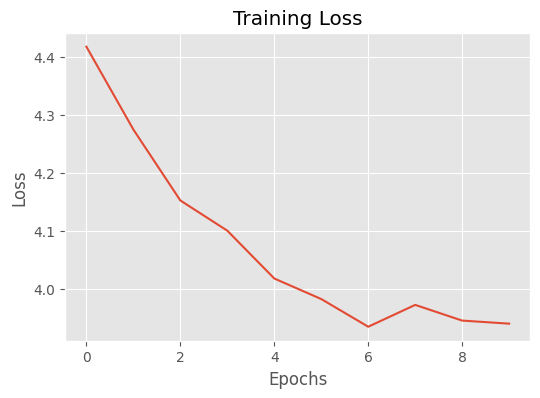

In [ ]:
import matplotlib.pyplot as plt

# ggplot 스타일 적용
plt.style.use("ggplot")

logs = loss_logging_callback.logs
# loss_logging_callback에서 기록한 손실 값 가져오기
losses = [log["loss"] for log in logs if "loss" in log]  # 'loss' 키가 있는 로그만 추출

plt.figure(figsize=(6, 4))  # 배경색 설정
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

학습을 계속할 수록 손실 값이 줄어드는 것을 확인할 수 있습니다. 이는 모델이 데이터를 더 잘 이해하고 있음을 의미합니다. 그러나 손실 값이 감소하는 속도가 느려지면 학습이 수렴(convergence)하고 있음을 나타낼 수 있습니다. 이 경우 학습률을 조정하거나 다른 하이퍼파라미터를 조정하여 성능을 향상시킬 수 있습니다. 이제 학습된 모델을 저장해보죠.

In [ ]:
# 모델 이름 및 저장 경로 설정
model_name = "TinySolar-308m-4k-finetune"  # 파인튜닝된 모델 이름
save_path = output_dir / model_name  # 모델 저장 경로 생성

# 사전 학습된 모델 저장
pretrained_model.save_pretrained(save_path.as_posix())  # 모델 가중치와 구성 파일 저장

# 토크나이저 저장
tokenizer.save_pretrained(save_path.as_posix())  # 토크나이저 관련 파일(vocab 등) 저장

('../data/output/TinySolar-308m-4k-finetune/tokenizer_config.json',
 '../data/output/TinySolar-308m-4k-finetune/special_tokens_map.json',
 '../data/output/TinySolar-308m-4k-finetune/tokenizer.model',
 '../data/output/TinySolar-308m-4k-finetune/added_tokens.json',
 '../data/output/TinySolar-308m-4k-finetune/tokenizer.json')

## 모델의 성능 확인

모델 학습을 진행하면서 모델의 체크포인트(임시 저장)를 만들었습니다. 이 체크포인트를 불러와서 사용해보는 코드는 아래와 같습니다. 모델의 토크나이저는 이전과 마찬가지로 Solar 토크나이저를 사용하고 `TextStreamer` 객체를 설정하여 생성되는 텍스트를 출력합니다.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

# 1. 토크나이저 설정
model_name_or_path = "upstage/TinySolar-248m-4k"
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

# 2. 중간 체크포인트 모델 로드
checkpoint_path = "../data/output/checkpoint-10000"
model2 = AutoModelForCausalLM.from_pretrained(
    checkpoint_path,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

# 3. 프롬프트 설정
prompt = "I am an engineer. I love"

# 4. 입력 토큰화
inputs = tokenizer(prompt, return_tensors="pt").to(model2.device)

# 5. 텍스트 스트리머 설정
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

# 6. 텍스트 생성
outputs = model2.generate(
    **inputs,
    streamer=streamer,
    use_cache=True,
    max_new_tokens=64,
    do_sample=True,
    temperature=1.0,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


what I see in people like me and so, for me, my passion is a passion for health and love. As long and as I am an entrepreneur (both in the fields of health marketing and customer sales, there is a difference that must be recognised here. In this issue, I am in charge of what I


위의 결과를 보면 처음 시작했던 모델과 비교하면 훨씬 더 자연스러운 텍스트가 생성되는 것을 확인할 수 있습니다. 다만 맥락은 이해하기 어렵네요. 

# 모델 평가

LLM 모델 평가는 전통적인 기계학습 모델과 달리 복잡하고 다면적인 과정입니다. 주요 평가 방법으로는 벤치마크 평가와 리더보드 평가가 존재합니다. 다만 실제 구현하는 코드는 이 글의 범위를 벗어나기에 생략하겠습니다.

## 벤치마크 평가법

벤치마크 평가는 표준화된 데이터셋과 태스크를 사용하여 모델의 성능을 객관적으로 측정합니다.

- LM Evaluation Harness: EleutherAI에서 개발한 도구로, 다양한 벤치마크 태스크에 대해 LLM을 평가할 수 있습니다. 다음 [GitHub 리포지토리](https://github.com/EleutherAI/lm-evaluation-harness)에서 찾을 수 있습니다.
- TruthfulQA: 모델의 진실성과 정확성을 평가하는 벤치마크로, 817개의 질문을 포함하며 건강, 법률, 금융 등 38개 주제를 다룹니다. TruthfulQA 벤치마크에 대한 자세한 내용은 [이 논문](https://arxiv.org/abs/2109.07958)에서 읽을 수 있으며 구현 코드는 다음 [GitHub 리포지토리](https://github.com/sylinrl/TruthfulQA)에서 확인할 수 있습니다.

## 리더보드 평가법

리더보드는 다양한 모델의 성능을 비교할 수 있는 플랫폼을 제공합니다.

- Hugging Face [리더보드](https://huggingface.co/open-llm-leaderboard): 다양한 LLM 모델의 성능을 비교할 수 있는 플랫폼입니다. 전문가나 일반 사용자가 직접 모델의 출력을 평가하는 방식입니다.

# 마치며

이번 강의에서는 LLM 사전 학습을 위한 데이터 수집, 정제, 패키징, 모델 구성, 가중치 초기화, 학습의 과정을 배웠습니다. 이러한 과정을 통해 LLM 모델을 효율적으로 학습하고 성능을 평가할 수 있습니다. 이제 여러분도 LLM 모델을 구축하고 평가할 수 있는 능력을 갖추셨습니다. 앞으로도 다양한 업무에 LLM 모델을 적용하여 더 나은 성능을 달성하시기 바랍니다.

> AI는 새로운 전기와 같아서 삶의 거의 모든 영역을 변화시키고 개선할 것입니다. - [Andrew Ng](https://www.andrewng.org/)

## Reference

- [Pretraining LLMs](https://learn.deeplearning.ai/courses/pretraining-llms/lesson/xg5n5/why-pre-training)
